Checking framerate format

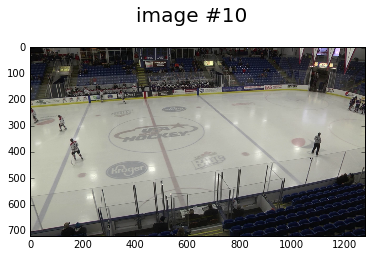

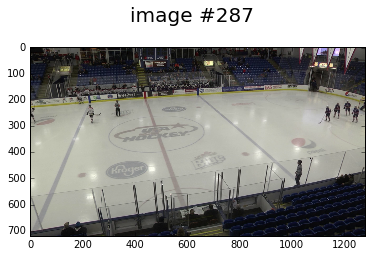

In [1]:
#check if frames can be displayed
import pylab
import imageio
filename = 'U18 vs Waterloo Period 1.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')
nums = [10, 287]
for num in nums:
    image = vid.get_data(num)
    fig = pylab.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    pylab.imshow(image)
pylab.show()

In [2]:
#check if images are 60 per second
print(vid.get_meta_data())


{'source_size': (1280, 720), 'plugin': 'ffmpeg', 'size': (1280, 720), 'fps': 59.94, 'nframes': 117086, 'duration': 1953.39, 'ffmpeg_version': '2.8.11-0ubuntu0.16.04.1 built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609'}


In [3]:
help(vid.iter_data)

Help on method iter_data in module imageio.core.format:

iter_data() method of imageio.plugins.ffmpeg.Reader instance
    iter_data()
    
    Iterate over all images in the series. (Note: you can also
    iterate over the reader object.)



In [4]:
frame_no = 2660
print("{} minute, {:.2f} second".format((frame_no-1)//(vid.get_meta_data()['fps']*vid.get_meta_data()['fps']), (frame_no-1)//vid.get_meta_data()['fps'])) 
#so frames are such that
#frame_no // frame_rate minute, frame no % frame_rate second

0.0 minute, 44.00 second


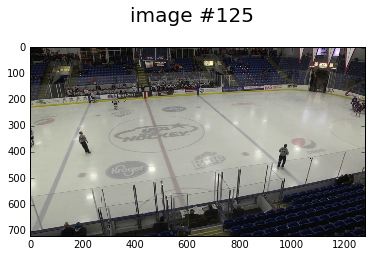

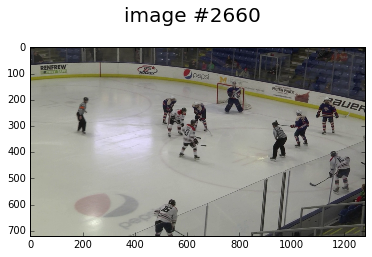

In [5]:
#convert timestamp to frame number 
#there are about 59.94 frames per second
#timestamp is in minutes:seconds
#frames are in numbers 
#frame number 60 = 1 second mark
#frame number 120 = 2 second mark
#frame number 125 = 2 min, 4 second mark
#lets test this theory

nums = [125, frame_no]
for num in nums:
    image = vid.get_data(num)
    fig = pylab.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    pylab.imshow(image)
pylab.show()
#issue identified, frame no does not match calculated timestamp

In [6]:
import cv2
cv2.__version__

'3.2.0'

In [7]:
#play video using OpenCv2

import numpy as np
import cv2

cap = cv2.VideoCapture('U18 vs Waterloo Period 1.mp4')

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the resulting frame
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [8]:
#subtract Background from video

import numpy as np
import cv2

cap = cv2.VideoCapture('U18 vs Waterloo Period 1.mp4')

fgbg = cv2.createBackgroundSubtractorKNN()

while(1):
    ret, frame = cap.read()

    fgmask = fgbg.apply(frame)

    cv2.imshow('frame',fgmask)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

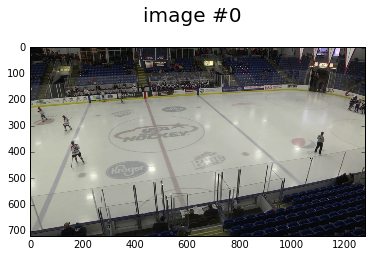

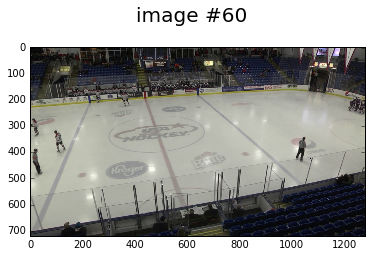

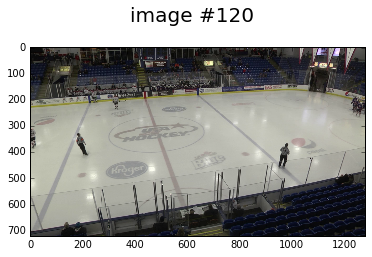

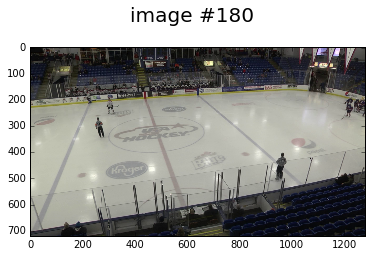

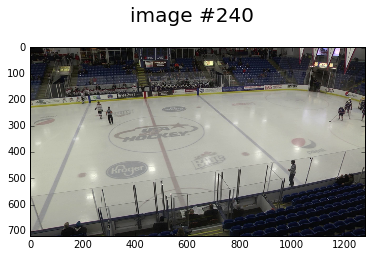

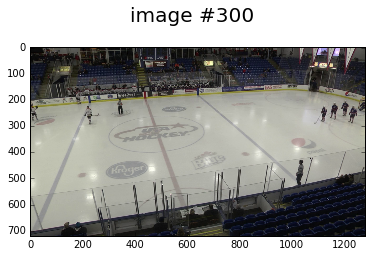

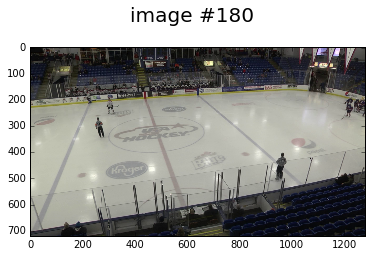

In [9]:
#new idea: check every 60th frame to align by second
nums = [0,60, 120,180, 180+60,180+60+60, 180]
for num in nums:
    image = vid.get_data(num)
    fig = pylab.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    pylab.imshow(image)
pylab.show()

```1 second = 60 frames,
1 minutes = 60 * 60 frames = 3600
conversion = minute * 3600 + second * 60 + rest
```

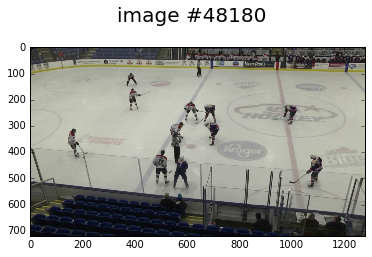

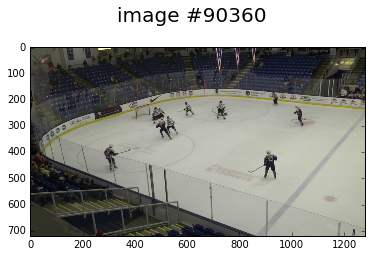

In [10]:
#testing the above theory by finding impact
nums = [(13*60*60)+(23*60) + 0, (25*60*60)+(6*60)+0]
for num in nums:
    image = vid.get_data(num)
    fig = pylab.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    pylab.imshow(image)
pylab.show()
#proved earlier formula

In [11]:
print(vid.get_meta_data())

{'source_size': (1280, 720), 'plugin': 'ffmpeg', 'size': (1280, 720), 'fps': 59.94, 'nframes': 117086, 'duration': 1953.39, 'ffmpeg_version': '2.8.11-0ubuntu0.16.04.1 built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609'}


In [12]:
117086/88603

1.3214676703949075

```
Plan:
iterate over every 60th frame of video
label all frames as no impact
Then all frames listed in file as impact as impact
```

In [13]:
#Read the data
import pandas as pd
data = pd.read_excel('labeled video .xlsx')

In [14]:
#get timestamps where 'Period\n(Video)' = 1 and 'Impact Classifn ' = 'I'
#due to issues with Python string/dict useage, I converted 
#'Impact Classifn ' to 'impact_class' and 'Period\n(Video)' to 'video_period'
vals = data.loc[data['impact_class'] == 'I']
vals = (vals.loc[vals['video_period'] == 1])
print(vals['Video time'])

3281         5:07
3910        12:11
14585        5:03
19728        5:03
26080       16:10
27829       23:22
42862        7:09
43734        9:07
55539        3:38
55848       11:34
61511       16:03
62608       16:05
63994       19:39
87153        9:31
88516       13:23
88517       14:12
88519    25:01:00
88520    25:02:00
88535       13:55
88536       13:55
88537       18:27
88538       18:28
88539       23:20
88540       23:21
88558        9:23
88559    25:06:00
88560    25:06:00
88576    28:12:00
88593       16:29
88594       16:52
88595       20:28
88597       16:46
Name: Video time, dtype: object


In [15]:
impact_time_strings = list(vals['Video time'])

In [16]:
# import re
# impact_timestamp = dict()
# for idx, val in enumerate(impact_time_strings):
#     impact_timestamp[idx] = re.findall(r'\d+', val)
import re
impact_timestamp = dict()
for val in impact_time_strings:
    impact_timestamp[val] = re.findall(r'\d+', val)

In [17]:
# frame_nums = list()
# for val in impact_timestamp.items():
#     print("frame:{}, time:{}:{}".format(val[0], int(val[1][0]), int(val[1][1])))
#     frame_nums.append((int(val[1][0])*60*60)+ (int(val[1][1])*60))
frame_nums = dict()
for val in impact_timestamp.items():
    print("frame:{}, time:{}:{}".format(val[0], int(val[1][0]), int(val[1][1])))
    frame_nums[val[0]] = int(val[1][0])*60*60 + int(val[1][1])*60

frame:11:34, time:11:34
frame:19:39, time:19:39
frame:18:27, time:18:27
frame:16:46, time:16:46
frame:25:01:00, time:25:1
frame:9:31, time:9:31
frame:9:23, time:9:23
frame:16:03, time:16:3
frame:5:07, time:5:7
frame:25:02:00, time:25:2
frame:23:20, time:23:20
frame:7:09, time:7:9
frame:16:10, time:16:10
frame:16:52, time:16:52
frame:14:12, time:14:12
frame:18:28, time:18:28
frame:16:05, time:16:5
frame:12:11, time:12:11
frame:23:21, time:23:21
frame:13:23, time:13:23
frame:3:38, time:3:38
frame:5:03, time:5:3
frame:20:28, time:20:28
frame:13:55, time:13:55
frame:9:07, time:9:7
frame:16:29, time:16:29
frame:28:12:00, time:28:12
frame:25:06:00, time:25:6
frame:23:22, time:23:22


In [18]:
for key, val in frame_nums.items():
    print(key, val)

11:34 41640
19:39 70740
18:27 66420
25:01:00 90060
9:31 34260
9:23 33780
16:03 57780
5:07 18420
16:46 60360
23:20 84000
7:09 25740
16:05 57900
16:52 60720
14:12 51120
18:28 66480
5:03 18180
16:10 58200
12:11 43860
23:21 84060
13:23 48180
3:38 13080
25:02:00 90120
20:28 73680
13:55 50100
9:07 32820
16:29 59340
28:12:00 101520
25:06:00 90360
23:22 84120


In [19]:
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/lib/python3/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/lib/python3/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this war

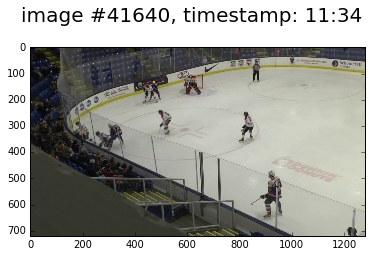

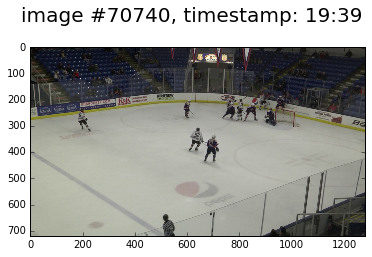

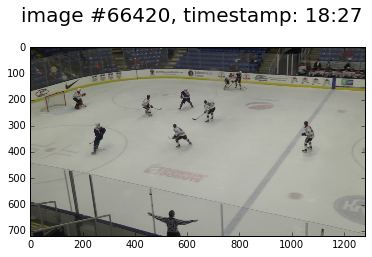

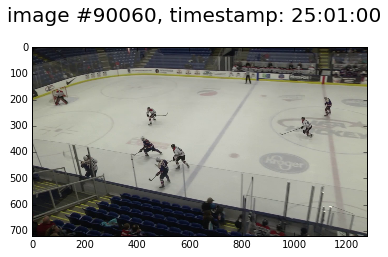

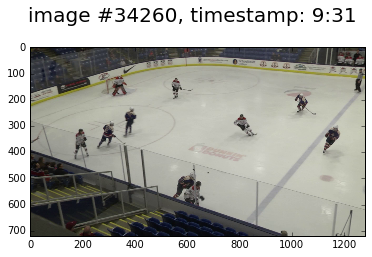

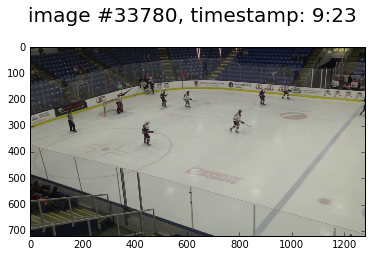

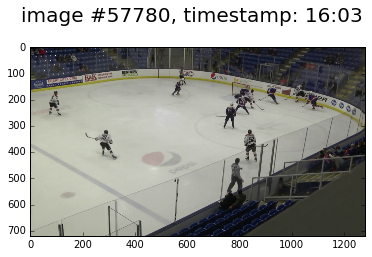

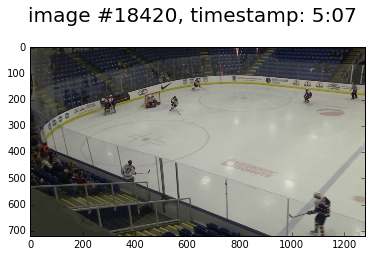

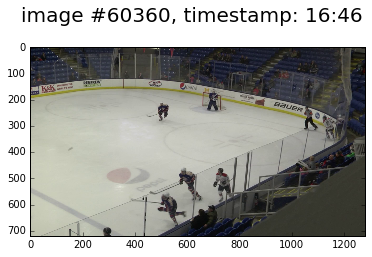

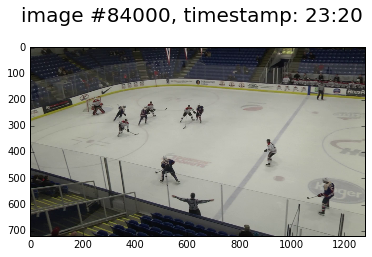

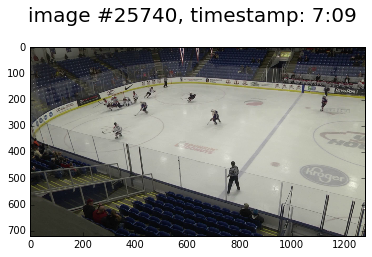

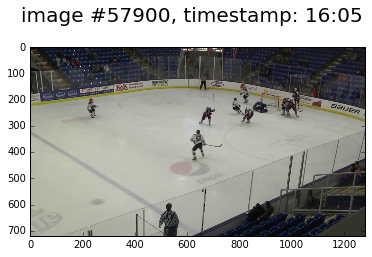

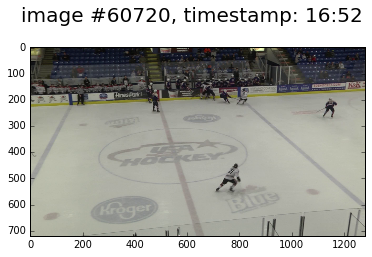

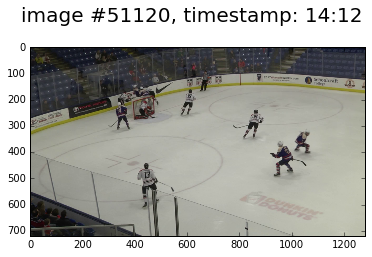

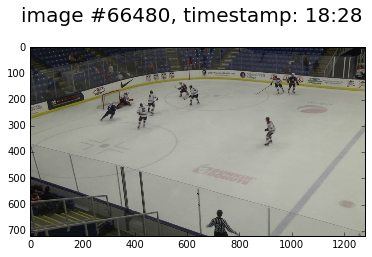

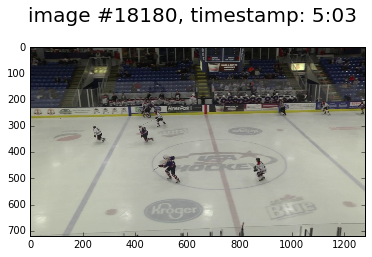

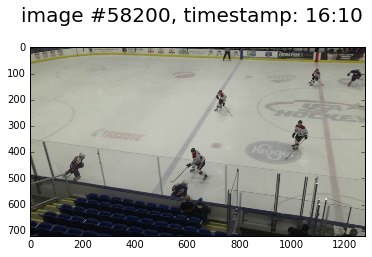

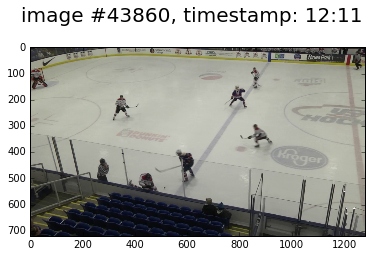

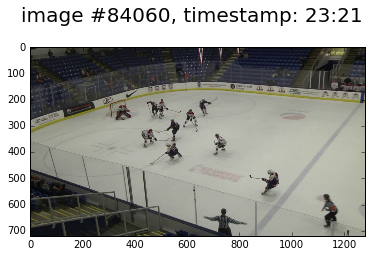

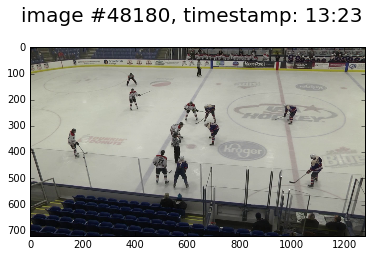

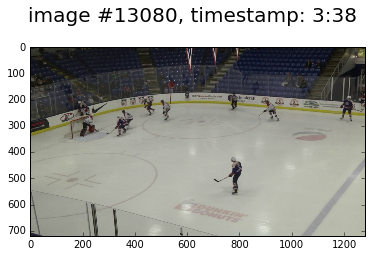

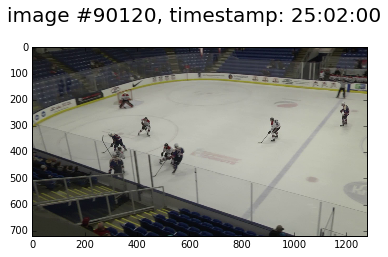

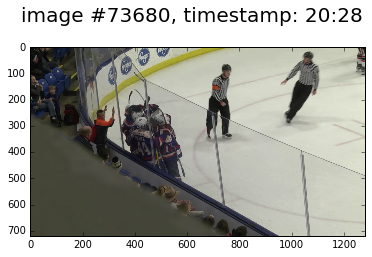

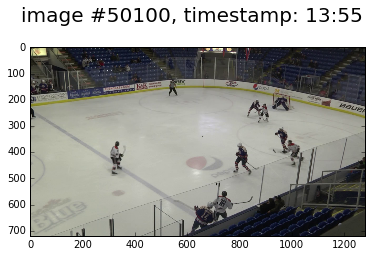

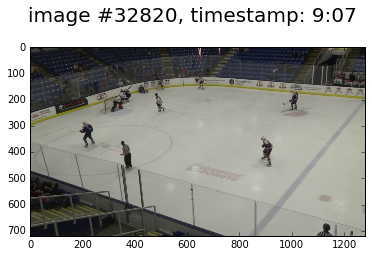

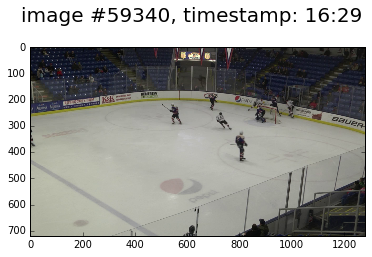

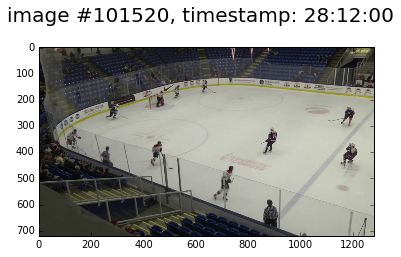

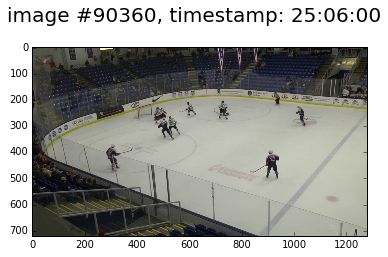

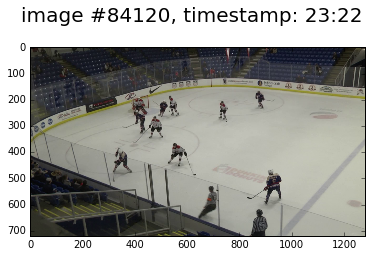

In [20]:
for key, val in frame_nums.items():
    image = vid.get_data(val)
    fig = pylab.figure()
    fig.suptitle('frame #{}, timestamp: {}'.format(val, key), fontsize=20)
    plt.imshow(image)
    plt.savefig(filename='data/image{}.jpg'.format(key), dpi='figure')
pylab.show()